In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langgraph.graph import StateGraph
from typing_extensions import TypedDict

class AgentState(TypedDict):
    query: str
    answer: str
    tax_base_equation: str #과세표준 계산 수식
    tax_deduction: str #공제액
    market_ratio: str #공정시장가액비율
    tax_base: str #과세표준 계산

graph_builder = StateGraph(AgentState)

----------------

## HuggingFaceEmbeddings / Qwen3-Embedding-0.6B을 사용한 임베딩

In [3]:
# from langchain_community.embeddings import HuggingFaceEmbeddings
# from langchain_community.vectorstores import Chroma
# from langchain.text_splitter import RecursiveCharacterTextSplitter
# from langchain_community.document_loaders import TextLoader

# # 1. 임베딩 모델 준비
# # 사용할 모델 이름을 지정하고, GPU를 사용하도록 설정합니다.
# model_name = "Qwen/Qwen3-Embedding-0.6B"
# model_kwargs = {'device': 'cuda'}
# encode_kwargs = {'normalize_embeddings': False} # 모델에 따라 정규화 옵션 조절

# embedding_function = HuggingFaceEmbeddings(
#     model_name=model_name,
#     model_kwargs=model_kwargs,
#     encode_kwargs=encode_kwargs
# )

# # 2. 문서 로드 및 분할
# loader = TextLoader("./documents/real_estate_tax.txt")
# documents = loader.load()
# text_splitter = RecursiveCharacterTextSplitter(
#     chunk_size=1500, 
#     chunk_overlap=100,
#     separators=["\n\n", "\n"]
# )
# docs = text_splitter.split_documents(documents)

# # 3. ChromaDB에 문서 임베딩 및 저장
# vector_store = Chroma.from_documents(
#     documents=docs,
#     embedding=embedding_function,
#     collection_name="qwen_real_estate_tax_collection",
#     persist_directory="./qwen_real_estate_tax_collection" # DB를 디스크에 저장
# )

# print("임베딩 및 벡터 저장소 생성이 완료되었습니다.")

In [4]:
# retriever = vector_store.as_retriever(search_kwargs={"k": 3})
# retriever.invoke('주택에 대한 종합부동산세 계산시 과세표준을 계산하는 방법을 수식으로 표현해서 알려주세요')

----------------

In [5]:
# from langchain_text_splitters import RecursiveCharacterTextSplitter
# from langchain_community.document_loaders import TextLoader

# text_spliiter = RecursiveCharacterTextSplitter(
#     chunk_size=1500, 
#     chunk_overlap=100,
#     separators=["\n\n", "\n"]
#     )

# loader = TextLoader('./documents/real_estate_tax.txt')
# document_list = loader.load_and_split(text_spliiter)

In [6]:
# document_list

-----------

In [7]:
# from langchain_chroma import Chroma
# from langchain_upstage import UpstageEmbeddings
# from langchain_openai import OpenAIEmbeddings


# # embedding_function = UpstageEmbeddings(
# #     model="embedding-query"
# # )

# embedding_function = OpenAIEmbeddings(
#     model="text-embedding-3-large"
# )

# vector_store = Chroma.from_documents(
#     documents=document_list,
#     embedding=embedding_function,
#     collection_name="real_estate_tax_collection",
#     persist_directory="./real_estate_tax_collection"
# )

# retriever = vector_store.as_retriever(
#     search_kwargs={"k": 3}
# )

In [5]:
from langchain_chroma import Chroma
from langchain_upstage import UpstageEmbeddings
from langchain_openai import OpenAIEmbeddings

# embedding_function = UpstageEmbeddings(
#     model="embedding-query"
#     # model="embedding-passage"
# )

embedding_function = OpenAIEmbeddings(
    model="text-embedding-3-large"
)

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name="real_estate_tax_collection",
    persist_directory="./real_estate_tax_collection"
)

retriever = vector_store.as_retriever(
    search_kwargs={"k": 3}
)

In [6]:
query = '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?'

In [7]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

rag_prompt = hub.pull("rlm/rag-prompt")

In [11]:
# from langchain_upstage import ChatUpstage

# llm = ChatUpstage(
#     model="solar-pro2",
#     )

# sllm = ChatUpstage(
#     model = "solar-mini"
# )

In [12]:
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(
#     model = 'Qwen/Qwen3-0.6B',
#     temperature = 0.0,
#     base_url = 'http://localhost:8000/v1',
#     api_key = '',
# )

In [8]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.0
)

In [9]:
tax_base_retrieval_chain =( 
    {'context': retriever, 'question': RunnablePassthrough()}
    | rag_prompt 
    | llm   
    | StrOutputParser()
)

tax_base_equation_prompt = ChatPromptTemplate.from_messages([
    ('system', '사용자의 질문에서 과세표준을 계산하는 방법을 수식으로 나타내주세요. 부연설명 없이 수식만 리턴해주세요'),
    ('human', '{tax_base_equation_information}')
])

tax_base_equation_chain = (
    {'tax_base_equation_information': RunnablePassthrough()}
    | tax_base_equation_prompt
    | llm   
    | StrOutputParser()
    )

tax_base_chain = {'tax_base_equation_information': tax_base_retrieval_chain} | tax_base_equation_chain

def get_tax_base_equation(state: AgentState) -> AgentState:
    tax_base_equation_question = '주택에 대한 종합부동산세 계산시 과세표준을 계산하는 방법을 수식으로 표현해서 알려주세요'
    tax_base_equation = tax_base_chain.invoke(tax_base_equation_question)
    return {'tax_base_equation': tax_base_equation}

In [15]:
# {'tax_base_equation': '과세표준 = (합산 주택 공시가격 - 공제액) × 공정시장가액비율'}

In [10]:
tax_deduction_chain = (
    {'context': retriever, 'question': RunnablePassthrough()}
    | rag_prompt
    | llm
    | StrOutputParser()
)

def get_tax_deduction(state: AgentState) -> AgentState:
    tax_deduction_question = '주택에 대한 종합부동산세 계산시 공제금액을 알려주세요'
    tax_deduction = tax_deduction_chain.invoke(tax_deduction_question)
    return {'tax_deduction': tax_deduction}

In [11]:
# {'tax_deduction': '주택에 대한 종합부동산세 계산 시 1세대 1주택자에게는 12억 원이 공제되고, 일반 납세의무자에게는 9억 원이 공제됩니다. 법인이나 법인으로 보는 단체의 경우에는 6억 원이 공제됩니다.'}

In [12]:
from datetime import date
from langchain_tavily import TavilySearch

tavily_search_tool = TavilySearch(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True
)

tax_market_ratio_prompt = ChatPromptTemplate.from_messages([
    ('system', f'아래 정보를 기반으로 공정시장 가액비율을 계산해주세요\n\nContext:\n{{context}}'),
    ('human', '{query}')
])


def get_market_ratio(state: AgentState) -> AgentState:
    query = f'오늘 날짜:({date.today()})에 해당하는 주택 공시가격 공정시장가액비율은 몇 %인가요?'
    context = tavily_search_tool.invoke(query)
    tax_market_ratio_chain = (
        tax_market_ratio_prompt
        | llm
        | StrOutputParser()
    )
    market_ratio = tax_market_ratio_chain.invoke({'context': context, 'query': query})
    return {"market_ratio": market_ratio}

In [19]:
# {'market_ratio': '2025년 기준으로 주택의 공시가격 공정시장가액비율은 60%입니다. 단, 9억 원을 초과하는 주택의 경우 비율은 45%가 적용됩니다.'}

In [13]:
tax_base_calculation_prompt = ChatPromptTemplate.from_messages(
    [
        ('system',"""
주어진 내용을 기반으로 과세표준을 계산해주세요

과세표준 계산 공식: {tax_base_equation}
공제금액: {tax_deduction}
공정시장가액비율: {market_ratio}"""),
        ('human', '사용자 주택 공시가격 정보: {query}')
    ]
)

def calculate_tax_base(state: AgentState) -> AgentState:
    tax_base_equation = state['tax_base_equation']
    tax_deduction = state['tax_deduction']
    market_ratio = state['market_ratio']
    query = state['query']
    tax_base_calculation_chain = (
        tax_base_calculation_prompt
        | llm
        | StrOutputParser()
    )
    tax_base = tax_base_calculation_chain.invoke({
        'tax_base_equation': tax_base_equation,
        'tax_deduction': tax_deduction,
        'market_ratio': market_ratio, 
        'query': query
    })
    return {'tax_base': tax_base}

In [14]:
tax_rate_calculation_prompt = ChatPromptTemplate.from_messages([
    ('system', '''당신은 종합부동산세 계산 전문가입니다. 아래 문서를 참고해서 사용자의 질문에 대한 종합부동산세를 계산해주세요
    
    종합부동산세 세율:{context}'''),
    ('human', '''과세표준과 사용자가 소지한 주택의 수가 아래와 같을 때 종합부동산세를 계산해주세요
    
    과세표준: {tax_base}
    주택 수: {query}''')
])

def calculate_tax_rate(state: AgentState):
    query = state['query']
    tax_base = state['tax_base']
    context = retriever.invoke(query)
    tax_rate_chain = (
        tax_rate_calculation_prompt
        | llm
        | StrOutputParser()
    )
    tax_rate = tax_rate_chain.invoke({
        'context': context,
        'tax_base': tax_base,
        'query': query
        })
    print(f'tax_rate: {tax_rate}')

    return {'answer': tax_rate}

In [15]:
graph_builder.add_node('get_tax_base_equation', get_tax_base_equation)
graph_builder.add_node('get_tax_deduction', get_tax_deduction)
graph_builder.add_node('get_market_ratio', get_market_ratio)
graph_builder.add_node('calculate_tax_base', calculate_tax_base)
graph_builder.add_node('calculate_tax_rate', calculate_tax_rate)

In [16]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'get_tax_base_equation')
graph_builder.add_edge(START, 'get_tax_deduction')
graph_builder.add_edge(START, 'get_market_ratio')
graph_builder.add_edge('get_tax_base_equation', 'calculate_tax_base')
graph_builder.add_edge('get_tax_deduction', 'calculate_tax_base')
graph_builder.add_edge('get_market_ratio', 'calculate_tax_base')
graph_builder.add_edge('calculate_tax_base', 'calculate_tax_rate')
graph_builder.add_edge('calculate_tax_rate', END)

In [17]:
graph = graph_builder.compile()

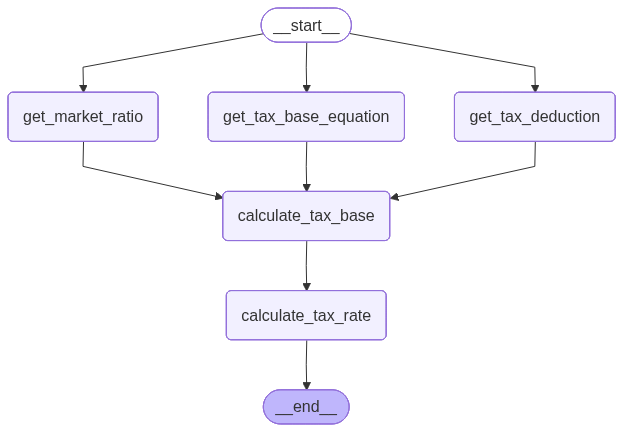

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
initial_state = {'query': query}
graph.invoke(initial_state)

tax_rate: 주어진 정보를 바탕으로 과세표준이 11.7억 원이고, 사용자는 총 3채의 주택을 소유하고 있습니다. 따라서, 3주택 이상 소유한 경우의 세율을 적용해야 합니다.

과세표준이 11.7억 원일 때, 3주택 이상 소유한 경우의 세율은 다음과 같습니다:

- 6억 원 초과 12억 원 이하: 360만 원 + (6억 원을 초과하는 금액의 1천분의 10)

과세표준이 11.7억 원이므로, 6억 원을 초과하는 금액은 11.7억 원 - 6억 원 = 5.7억 원입니다.

따라서, 종합부동산세는 다음과 같이 계산됩니다:

- 기본 세액: 360만 원
- 추가 세액: 5.7억 원 × 0.001 = 570만 원

총 종합부동산세 = 360만 원 + 570만 원 = 930만 원

따라서, 사용자는 930만 원의 종합부동산세를 납부해야 합니다.


{'query': '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?',
 'answer': '주어진 정보를 바탕으로 과세표준이 11.7억 원이고, 사용자는 총 3채의 주택을 소유하고 있습니다. 따라서, 3주택 이상 소유한 경우의 세율을 적용해야 합니다.\n\n과세표준이 11.7억 원일 때, 3주택 이상 소유한 경우의 세율은 다음과 같습니다:\n\n- 6억 원 초과 12억 원 이하: 360만 원 + (6억 원을 초과하는 금액의 1천분의 10)\n\n과세표준이 11.7억 원이므로, 6억 원을 초과하는 금액은 11.7억 원 - 6억 원 = 5.7억 원입니다.\n\n따라서, 종합부동산세는 다음과 같이 계산됩니다:\n\n- 기본 세액: 360만 원\n- 추가 세액: 5.7억 원 × 0.001 = 570만 원\n\n총 종합부동산세 = 360만 원 + 570만 원 = 930만 원\n\n따라서, 사용자는 930만 원의 종합부동산세를 납부해야 합니다.',
 'tax_base_equation': '과세표준 = (주택의 공시가격 합계 - 공제 금액) × 공정시장가액비율',
 'tax_deduction': '주택에 대한 종합부동산세 계산 시 공제금액은 1세대 1주택자의 경우 12억 원, 법인 또는 법인으로 보는 단체의 경우 6억 원, 그 외의 경우 9억 원입니다.',
 'market_ratio': '2025년 9월 24일에 해당하는 주택 공시가격 공정시장가액비율은 다음과 같습니다: 주택 가격이 6억 원 이하인 경우 44%가 적용되며, 6억 원을 초과하는 경우에는 45%가 적용됩니다.',
 'tax_base': '주어진 정보를 바탕으로 과세표준을 계산해보겠습니다.\n\n1. 주택의 공시가격 합계:\n   - 5억 원짜리 집 1채\n   - 10억 원짜리 집 1채\n   - 20억 원짜리 집 1채\n\n   총 공시가격 합계 = 5억 + 10억 + 20억 = 35억 원\n\n2. 공제 금액:\n   - 1세대 1주택자가 아닌 경우,